# TEST SCORE

In [ ]:
%%capture

!jupyter nbconvert --to html Test_Score.ipynb

[NbConvertApp] Converting notebook Test_Score.ipynb to html
[NbConvertApp] Writing 472363 bytes to Test_Score.html


In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

The data is loaded and some basics statistics showed.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_test_score = pd.read_csv('/content/gdrive/MyDrive/Kaggle/TestScores/test_scores.csv')

In [ ]:
df_test_score.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [ ]:
df_test_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   school           2133 non-null   category
 1   school_setting   2133 non-null   category
 2   school_type      2133 non-null   category
 3   classroom        2133 non-null   category
 4   teaching_method  2133 non-null   category
 5   n_student        2133 non-null   float64 
 6   student_id       2133 non-null   object  
 7   gender           2133 non-null   category
 8   lunch            2133 non-null   category
 9   pretest          2133 non-null   float64 
 10  posttest         2133 non-null   float64 
dtypes: category(7), float64(3), object(1)
memory usage: 85.9+ KB


In [ ]:
df_test_score.describe()

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest,posttest
count,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000
mean,11.264885,1.185654,0.741678,48.220816,0.643694,22.796531,0.504923,0.430380,54.955931,67.102203
std,6.516660,0.793525,0.437814,28.666968,0.479019,4.228893,0.500093,0.495245,13.563101,13.986789
min,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,22.000000,32.000000
25%,6.000000,1.000000,0.000000,24.000000,0.000000,20.000000,0.000000,0.000000,44.000000,56.000000
50%,11.000000,1.000000,1.000000,48.000000,1.000000,22.000000,1.000000,0.000000,56.000000,68.000000
75%,17.000000,2.000000,1.000000,74.000000,1.000000,27.000000,1.000000,1.000000,65.000000,77.000000
max,22.000000,2.000000,1.000000,96.000000,1.000000,31.000000,1.000000,1.000000,93.000000,100.000000


We drop the id since it has no role in the predicting task at all.

In [ ]:
df_test_score.drop(columns=['student_id'])

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,64.0,76.0
...,...,...,...,...,...,...,...,...,...,...
2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Does not qualify,39.0,55.0
2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,38.0,46.0
2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,45.0,51.0
2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,Male,Qualifies for reduced/free lunch,46.0,53.0


The data is transformed into categorical.

In [ ]:
for col in ['school' ,'school_setting', 'school_type', 'classroom', 'teaching_method', 'gender', 'lunch']:
    df_test_score[col] = df_test_score[col].astype('category')

We assure there is no null values.

In [ ]:
df_test_score.isnull().sum()

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

# EDA

We start the exploration of the numerical variables.

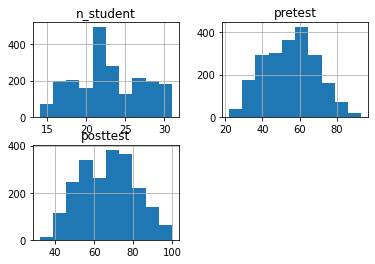

In [ ]:
df_test_score.hist()
plt.show()

More interesting than the single univariate plots, we can explore relationship betewwen each pair of variables. immediately it outcomes a linear relathionship between de variables pretest and posttest. By the other hand, it seems to exists a different behaviour in extreme regions of n_students where variable is too high or to low.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ae35b2ad0>,
      dtype=object)

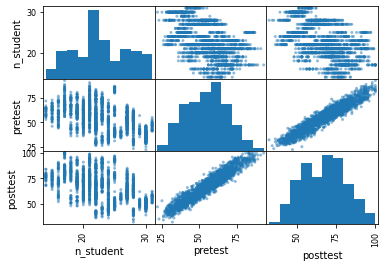

In [ ]:
attributes = ['n_student', 'pretest', 'posttest']
scatter_matrix(df_test_score[attributes])

How much variance is explained by pretest? The answer is below

In [ ]:
lin_reg =  LinearRegression()
x = np.array(df_test_score['pretest']).reshape(-1, 1)
y = np.array(df_test_score['posttest']).reshape(-1, 1)
lin_reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
r_sq = lin_reg.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.9041809248246262


A 90% of the variance is already explained by one variable. So, the strategy consists of including the most relevant variables and eliminating the noising ones. We also explore the categorical-response relationship.

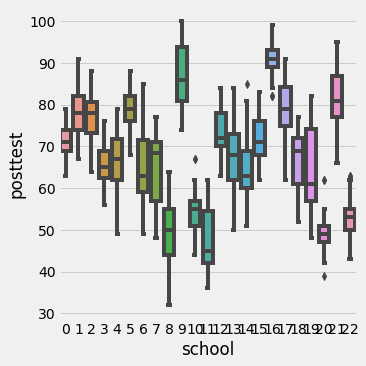

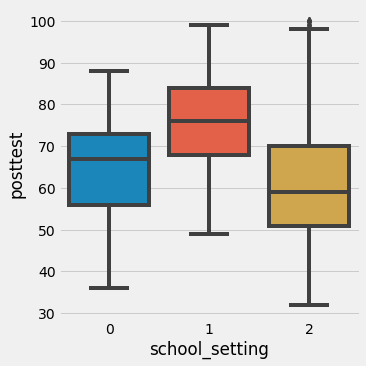

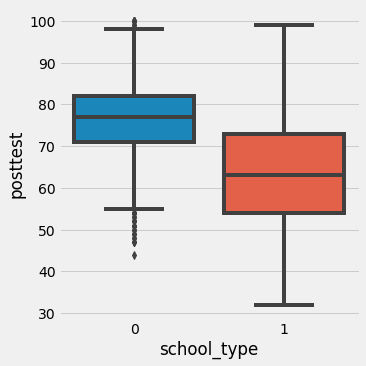

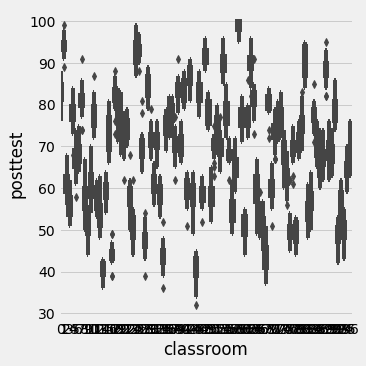

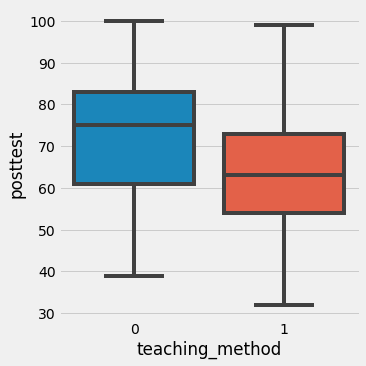

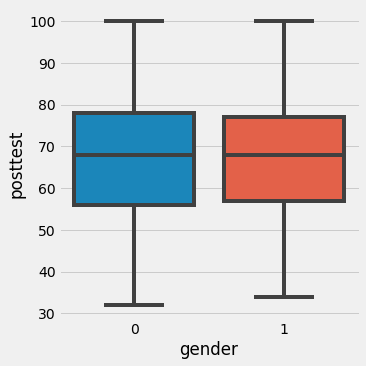

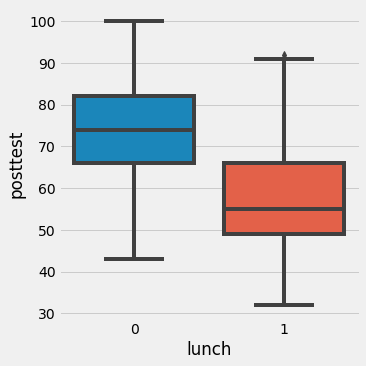

In [ ]:
for col in ['school' , 'school_setting', 'school_type', 'classroom', 'teaching_method', 'gender', 'lunch']:
  sns.catplot(x=col, y="posttest", kind="box", data=df_test_score)

# Variable Selection

We are going to use a base tree model to select the variables, i.e. random forest. We proved two more models (XGboost and CART) with the same variable selection. 

Let's use numerical encoding for the categorical features. 

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_score['gender'])
le.transform(df_test_score['gender'])
df_train = df_test_score
for col in ['school' , 'school_setting', 'school_type', 'classroom', 'teaching_method', 'gender', 'lunch']:
  le.fit(df_train[col])
  df_train[col] = le.transform(df_train[col])

In [ ]:
df_train = df_train.drop(columns=['student_id'])

Random forest simple training.

In [ ]:
X = df_train.drop(columns=['posttest'])
y = df_train['posttest']
dt_model = RandomForestRegressor()
dt_model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

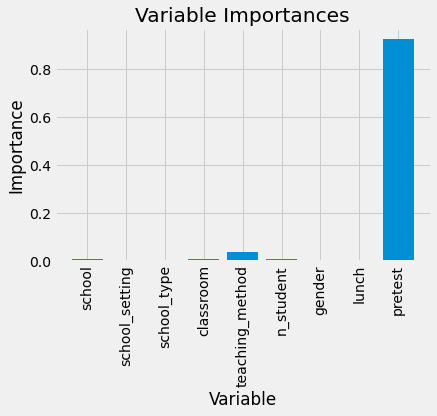

In [ ]:
feature_list = list(X.columns)
# Set the style
importances = list(dt_model.feature_importances_)
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

we select only those variables that explain the 95% of the variance. As a result, only two variables are selected.

Variable: pretest              Importance: 0.92
Variable: teaching_method      Importance: 0.04
Variable: school               Importance: 0.01
Variable: classroom            Importance: 0.01
Variable: n_student            Importance: 0.01
Variable: school_setting       Importance: 0.0
Variable: school_type          Importance: 0.0
Variable: gender               Importance: 0.0
Variable: lunch                Importance: 0.0


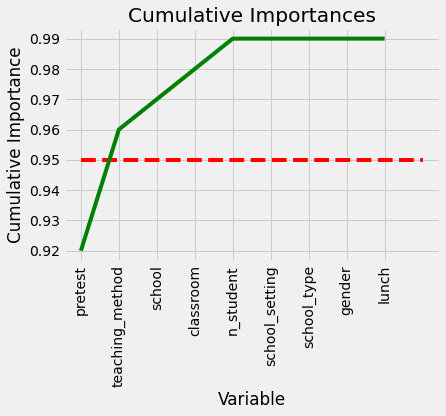

In [ ]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
df_sel_var = df_test_score[['pretest', 'teaching_method', 'posttest']]

# Model Training

finally, we train a simple linear regression model.

In [ ]:
X = df_sel_var.drop(columns=['posttest'])
y = df_sel_var['posttest']
X_training_data, X_testing_data, y_training_data, y_testing_data = train_test_split(X, y, test_size=0.3)

In [ ]:
final_model =  LinearRegression()
final_model.fit(X_training_data, y_training_data)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
r_sq = final_model.score(X_training_data, y_training_data)
print('coefficient of determination for training data:', r_sq)

coefficient of determination: 0.9469180895251497


In [ ]:
X1 = sm.add_constant(X_training_data)
test = sm.OLS(y_training_data, X1)
test2 = test.fit()
test2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               posttest   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.329e+04
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:56:25   Log-Likelihood:                -3862.5
No. Observations:                1493   AIC:                             7731.
Df Residuals:                    1490   BIC:                             7747.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              18.3125      0.377     48.612      0.000      17.574      19.051
pretest             0.9567      0.006    155.271      0.000       0.945       0.969
teaching_method    -5.9191      0.174    -33.952      0.000      -6.261      -5.577
==============================================================================
Omnibus:                        0.822   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.720
Skew:                           0.036   Prob(JB):                        0.698
Kurtosis:                       3.079   Cond. No.                         261.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Jarque-Bera test ensures the normality of the residuals and all the coeficients are significant and the rest of hipothesis underliying linear model, except ot Heteroskedasticity.

In [ ]:
from statsmodels.stats.diagnostic import het_white
white_test = het_white(test2.resid,  test2.model.exog)

In [ ]:
#white_test
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 2.8240123664719574, 'LM-Test p-value': 0.5876949014424486, 'F-Statistic': 0.7049721704319256, 'F-Test p-value': 0.5885380891538478}


In [ ]:
We check also the Heteroskedasticity assumption.

In [ ]:
y_pred = final_model.predict(X_testing_data)
print('Validation MAE', mean_absolute_error(y_testing_data, y_pred))
print('Validation RMSE', sqrt(mean_squared_error(y_testing_data, y_pred)))
print('Validation R^2', final_model.score(X_testing_data, y_testing_data))

Validation MAE 2.6131494057129663
Validation RMSE 3.3186807747149456
Validation R^2 0.9441227916890147


The predictions are in generral quiet accurate.